In [5]:
import numpy as np
import tqdm
from tqdm import trange
import torch
from torch import nn
import torch.nn.functional as F
import gym
import argparse
import math
import os
import torch.optim as optim
# import diff_discrete_event as des
import NEW_des_burst as des 
import matplotlib.pyplot as plt
import routing as rt
import policies as pol
import json
import torch.distributions.one_hot_categorical as one_hot_sample

import yaml


import pdb

class args:
    e = 'n_model.yaml'
    m = 'ppg.yaml'

# load config
with open(f'./configs/env/{args.e}', 'r') as f:
    env_config = yaml.safe_load(f)

with open(f'./configs/model/{args.m}', 'r') as f:
    model_config = yaml.safe_load(f)

name = env_config['name']
print(f'env: {name}')

model_name = model_config['name']
print(f'model: {model_name}')

# Set seed
if model_config['env']['model_seed'] is not None:
    torch.manual_seed(model_config['env']['model_seed'])

## Environment Parameters
# load network
if env_config['network'] is None:
    network = np.load(f'./env_data/{name}/{name}_network.npy')
else:
    network = env_config['network']

# load mu
if env_config['mu'] is None:
    mu = np.load(f'./env_data/{name}/{name}_mu.npy')
else:
    mu = env_config['mu']

network = torch.tensor(network).float()
mu = torch.tensor(mu).float()

orig_s, orig_q = network.size()

# repeat if server pools
num_pool = env_config['num_pool']
network = network.repeat_interleave(num_pool, dim = 0)
mu = mu.repeat_interleave(num_pool, dim = 0)

queue_event_options = env_config['queue_event_options']
if queue_event_options is not None:
    if queue_event_options == 'custom':
        queue_event_options = torch.tensor(np.load(f'./env_data/{name}/{name}_delta.npy'))
    else:
        queue_event_options = torch.tensor(queue_event_options)

h = torch.tensor(env_config['h'])

init_test_queues = torch.tensor([env_config['init_queues']]).float()
init_train_queues = torch.tensor([env_config['init_queues']]).float()

train_T = env_config['train_T']
test_T = env_config['test_T']

# arrival and service rates
lam_type = env_config['lam_type']
lam_params = env_config['lam_params']

if lam_params['val'] is None:
    lam_r = np.load(f'./env_data/{name}/{name}_lam.npy')
else:
    lam_r = lam_params['val']

def lam(t):
    if lam_type == 'constant':
        lam = lam_r
    elif lam_type == 'step':
        is_surge = 1*(t.data.cpu().numpy() <= lam_params['t_step'])
        lam = is_surge * np.array(lam_params['val1']) + (1 - is_surge) * np.array(lam_params['val2'])
    else:
        return 'Nonvalid arrival rate'
    
    return lam

def inter_arrival_dists(state, batch, t):
    exps = state.exponential(1, (batch, orig_q))
    lam_rate = lam(t)
    return exps / lam_rate

def service_dists(state, batch, t):
    return state.exponential(1, (batch, orig_q))

## Model parameters
model_name = model_config['name']
print(f'model: {model_name}')

checkpoint = model_config['checkpoint']
checkpoint_dir = f"./models/{name}/{model_name}/{model_name}"

num_epochs = model_config['opt']['num_epochs']
train_batch = model_config['opt']['train_batch']
test_batch = model_config['opt']['test_batch']
lr = model_config['opt']['lr']
betas = model_config['opt']['betas']
# threshold = model_config['opt']['threshold']

device = model_config['env']['device']
test_seed = model_config['env']['test_seed']
train_seed = model_config['env']['train_seed']
env_temp = model_config['env']['env_temp']
test_freq = model_config['env']['test_freq']
straight_through_min = model_config['env']['straight_through_min']

layers = model_config['param']['layers']
width = model_config['param']['width']
f_time = model_config['param']['f_time']

test_policy = model_config['policy']['test_policy']
train_policy = model_config['policy']['train_policy']
randomize = model_config['policy']['randomize']

sink_num_iter = model_config['policy']['sinkhorn']['num_iter']
sink_temp = model_config['policy']['sinkhorn']['temp']
sink_eps = model_config['policy']['sinkhorn']['eps']
sink_back_temp = model_config['policy']['sinkhorn']['back_temp']

# if checkpoint is None:
#     net = PriorityNet(orig_s, orig_q, layers, width, f_time = f_time).to(device)
# else:
#     net = torch.load(f'{checkpoint_dir}_{checkpoint}.pt')
# optimizer = optim.Adam(net.parameters(), lr = lr, betas = betas)

test_loss = []

if not os.path.exists(f'./loss'):
    os.makedirs(f'./loss')
if not os.path.exists(f"./models/{name}"):
    os.makedirs(f"./models/{name}")
if not os.path.exists(f"./models/{name}/{model_name}"):
    os.makedirs(f"./models/{name}/{model_name}")
## Train Loop
repeated_h = h.repeat(test_batch,network.shape[-2],1)
    
if train_seed is None:
    train_seed = int.from_bytes(os.urandom(4), 'big')

# When training, 'straight_through_min = True'
# net = net.to(device)

dq = des.DiffDiscreteEventSystem(network, mu, h, 
                            inter_arrival_dists, service_dists, 
                            queue_event_options = queue_event_options,
                            batch = 1, 
                            temp = env_temp, seed = train_seed,
                            device = torch.device(device),
                            burst_prob = 0.1, burst_factor = 10000)

# zero out the optimizer
# optimizer.zero_grad()

# save grads
back_outs = []
def action_hook(grad):
    #grad = torch.clamp(grad, -threshold,threshold)
    back_outs.append(grad.tolist())
    #return grad

nn_back_ins = []
def priority_hook(grad):
    nn_back_ins.append(grad.tolist())

# Train loop
obs, state = dq.reset(seed = train_seed)
total_cost = torch.tensor([[0.]]*train_batch).to(device)
time_weight_queue_len = torch.tensor([[0.]]*train_batch).to(device)


queue_lengths = []
for _ in trange(train_T):
    queues, time = obs


    
    # print(f"step {_}")
    # pdb.set_trace()

    action = torch.zeros_like(dq.network)
    
    obs, state, cost, event_time = dq.step(state, action)
    
    queue_lengths.append(queues)



env: n_model
model: ppg
model: ppg


100%|██████████| 30000/30000 [00:10<00:00, 2990.01it/s]


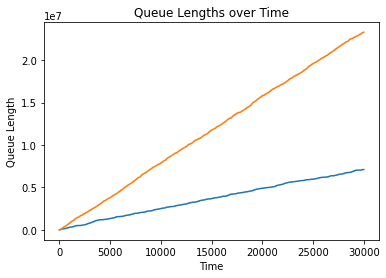

In [6]:
plt.plot(np.concatenate(queue_lengths)[:,0])
plt.plot(np.concatenate(queue_lengths)[:,1])
plt.xlabel('Time')
plt.ylabel('Queue Length')
plt.title('Queue Lengths over Time')
plt.show()


In [3]:
import torch
import numpy as np

network = torch.tensor([[1,0,0,0,0],[1,1,0,0,0],[1,0,1,0,0],[0,0,1,1,0],[0,0,0,1,1]]).float()

mu_diag = 1
mu_off_diag = 0.8
mu_scaling = torch.tensor(mu_diag * np.eye(5) + mu_off_diag * (np.ones((5,5)) - np.eye(5)))

mu = network * mu_scaling
h = torch.tensor([2,1.,1.,2, 1.])

In [5]:
network

tensor([[1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 0., 1., 0., 0.],
        [0., 0., 1., 1., 0.],
        [0., 0., 0., 1., 1.]])

In [4]:
mu

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.8000, 1.0000, 0.0000, 0.0000, 0.0000],
        [0.8000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.8000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.8000, 1.0000]], dtype=torch.float64)

In [7]:
state = np.random.default_rng(100)
batch = 100
time = 100
rho = 1

exp_arrival_1 = lambda state, t: state.exponential(1/(2.4*rho)) if t <= 100 else state.exponential(1/(0.4*rho))
exp_arrival_2 = lambda state, t: state.exponential(1/(0.6*rho)) if t <= 100 else state.exponential(1/(0.8*rho))
exp_arrival_3 = lambda state, t: state.exponential(1/(0.8*rho))
exp_arrival_4 = lambda state, t: state.exponential(1/(1.6*rho)) if t <= 100 else state.exponential(1/(0.8*rho))
exp_arrival_5 = lambda state, t: state.exponential(1/(0.6*rho))

interarrivals = torch.tensor([[exp_arrival_1(state, time), exp_arrival_2(state, time), exp_arrival_3(state, time), exp_arrival_4(state, time), exp_arrival_5(state, time)] for _ in range(batch)])



In [8]:
interarrivals

tensor([[5.2620e-01, 1.6608e+00, 7.4065e-01, 1.0379e-02, 1.1531e+00],
        [8.4673e-02, 6.7069e-01, 2.3341e+00, 7.9673e-01, 1.0615e+00],
        [8.4496e-01, 7.5756e-01, 8.5651e-01, 1.2820e+00, 2.4120e+00],
        [3.9825e-01, 4.5366e+00, 9.7110e-01, 3.6338e-01, 3.7524e-01],
        [1.4927e-01, 5.8688e+00, 1.8120e+00, 1.9562e-01, 2.2221e+00],
        [7.5317e-03, 2.1697e+00, 1.5579e-01, 5.4298e-01, 2.0555e+00],
        [1.2184e-02, 2.6421e-01, 1.3054e-01, 2.5458e-01, 2.2310e+00],
        [2.3911e-01, 1.5305e+00, 5.7118e-01, 1.6791e+00, 4.9966e+00],
        [2.7464e-01, 6.9820e-01, 2.2130e-01, 1.1730e+00, 1.2405e+00],
        [5.2361e-01, 5.3188e-01, 6.8690e-01, 9.1185e-01, 2.3164e+00],
        [1.0398e-01, 5.8365e-01, 4.1711e-01, 6.5675e-02, 1.1518e+00],
        [1.8999e-01, 6.4598e+00, 4.7345e-01, 3.5514e-01, 1.4566e-01],
        [4.3124e-01, 6.9513e-01, 2.7759e-01, 1.1914e-01, 3.4692e+00],
        [2.4380e-01, 8.1711e-01, 9.7525e-01, 1.7484e+00, 4.9276e+00],
        [2.9272e-02,